In [71]:
import numpy as np
import matplotlib.pyplot as plt

In [72]:
n = 100
x = np.random.rand(n, 1)
noise = np.random.normal(0, np.sqrt(0.01), size=(n,))
y = (np.sin(2 * np.pi * x).flatten() +
     np.cos(2 * np.pi * x).flatten() +
     noise)

print("x: ", x.shape)
print("y:", y.shape)

# Split into 80% train, 20% test
n_train = int(0.8 * n)
x_train, y_train = x[:n_train], y[:n_train]
x_test, y_test = x[n_train:], y[n_train:]

print(f'x_train: {x_train.shape}\ny_train: {y_train.shape}\nx_test: {x_test.shape}\ny_test: {y_test.shape}')

x:  (100, 1)
y: (100,)
x_train: (80, 1)
y_train: (80,)
x_test: (20, 1)
y_test: (20,)


In [73]:
# Parameters
n_rounds = 100
lr = 0.01
cuts = np.linspace(0, 1, 22)[1:-1]  # 20 thresholds between 0 and 1
iters_to_plot = [1, 10, 50, 100]

In [74]:
# Helper: fit a regression stump to target label on inputs x
def fit_stump(x, label, loss_type):
    best_err = np.inf
    best_params = None
    for thr in cuts:
        left = x.flatten() < thr
        right = ~left
        if not left.any() or not right.any():
            continue
        pl, pr = label[left].mean(), label[right].mean()
        preds = np.where(left, pl, pr)
        if (loss_type=='squared'):
            err = (((label - preds) ** 2).sum())/2
        else:
            err = np.abs(label - preds).sum()
        if err < best_err:
            best_err = err
            best_params = (thr, pl, pr)
    return best_params  # threshold, prediction_left, prediction_right



In [75]:
results = {}
for loss_type in ['squared', 'absolute']:
    # Initialize predictions
    F_train = np.zeros_like(y_train)
    F_test = np.zeros_like(y_test)
    train_loss = []
    stumps = []
    pred_iters_train = {}
    pred_iters_test = {}
    
    for t in range(1, n_rounds + 1):
        # Compute negative gradient
        if loss_type == 'squared':
            grad = y_train - F_train
        else:
            grad = np.sign(y_train - F_train)
        
        thr, pl, pr = fit_stump(x_train, grad, loss_type)
        stumps.append((thr, pl, pr))
        
        pred_train = np.where(x_train.flatten() < thr, pl, pr)
        pred_test = np.where(x_test.flatten() < thr, pl, pr)
        
        # Update F
        F_train += lr * pred_train
        F_test += lr * pred_test
        
        if loss_type == 'squared':
            train_loss.append((((y_train - F_train) ** 2).sum())/2)
        else:
            train_loss.append(np.abs(y_train - F_train).sum())
        
        #for plotting
        if t in iters_to_plot:
            x_grid = np.linspace(0, 1, 200)
            F_grid = np.zeros_like(x_grid)
            for thre, p_left, p_right in stumps:         #threshold, prediction left, prediction right
                mask_grid = x_grid < thre
                F_grid += lr * np.where(mask_grid, p_left, p_right)
            pred_iters_train[t] = (x_grid, F_grid)
            pred_iters_test[t] = (x_grid, F_grid)
    
    results[loss_type] = {
        'train_loss': train_loss,
        'pred_train': pred_iters_train,
        'pred_test': pred_iters_test,
        'stumps' : stumps
    }

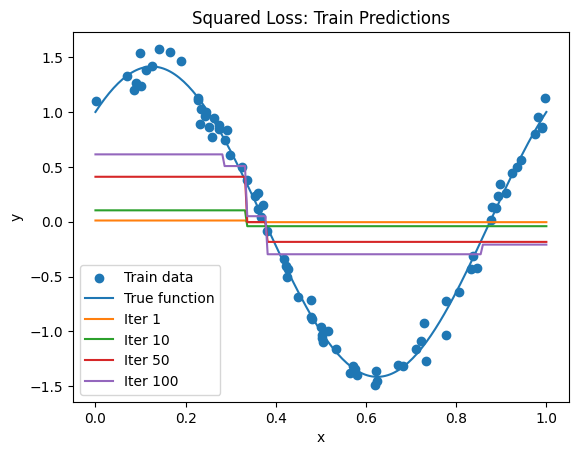

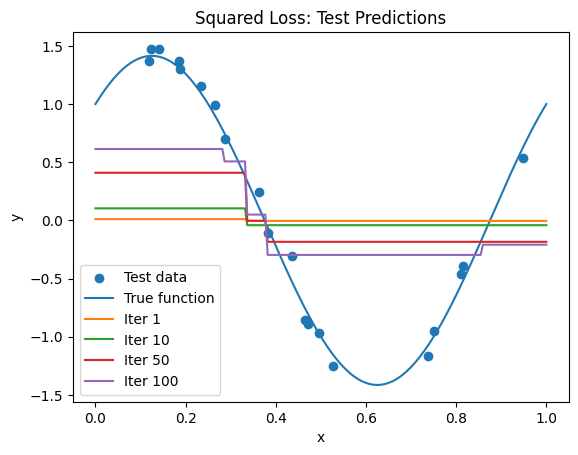

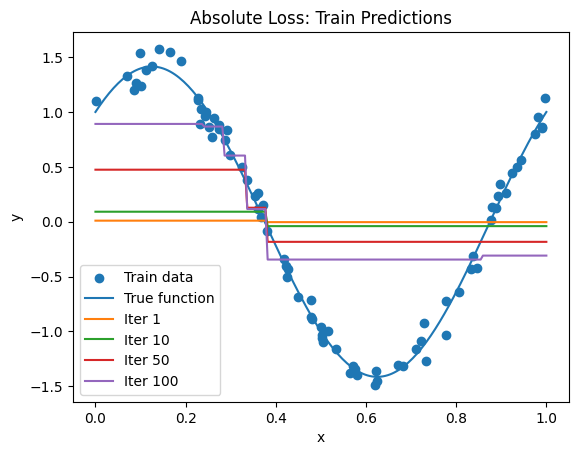

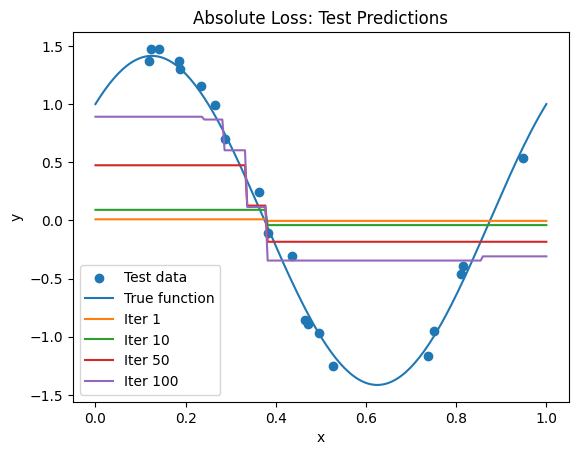

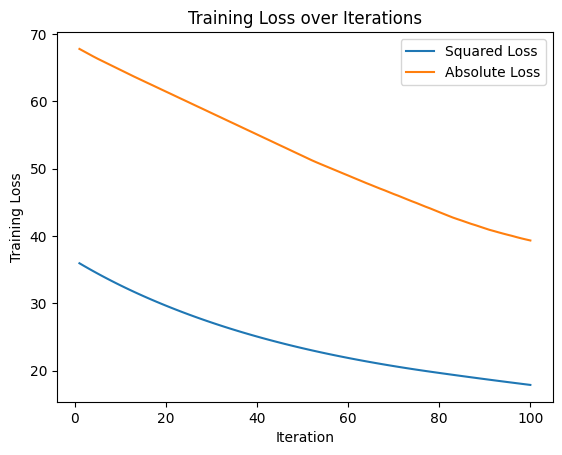

In [76]:
#Plotting
for loss_type in ['squared', 'absolute']:
    label = 'Squared' if loss_type == 'squared' else 'Absolute'
    # Ground truth curve
    x_grid = np.linspace(0, 1, 200)
    y_true = np.sin(2 * np.pi * x_grid) + np.cos(2 * np.pi * x_grid)
    
    # Train
    plt.figure()
    plt.scatter(x_train, y_train, label='Train data')
    plt.plot(x_grid, y_true, label='True function')
    for t in iters_to_plot:
        plt.plot(*results[loss_type]['pred_train'][t], label=f'Iter {t}')
    plt.title(f'{label} Loss: Train Predictions')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()
    
    # Test
    plt.figure()
    plt.scatter(x_test, y_test, label='Test data')
    plt.plot(x_grid, y_true, label='True function')
    for t in iters_to_plot:
        plt.plot(*results[loss_type]['pred_test'][t], label=f'Iter {t}')
    plt.title(f'{label} Loss: Test Predictions')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

# 3. Plot training loss over iterations for both losses
plt.figure()
plt.plot(range(1, n_rounds + 1), results['squared']['train_loss'], label='Squared Loss')
plt.plot(range(1, n_rounds + 1), results['absolute']['train_loss'], label='Absolute Loss')
plt.title('Training Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.legend()
plt.show()
